In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
from matplotlib import style
style.use('ggplot')

В данном алгоритме нам нужно найти наиболее подходящую гиперплоскость, разделяющую данные.

Алгоритм делит классы на первый и все остальные (можно назвать это бинарной классификацией в определенный момент, однако с множеством классов)

Допустим у нас есть вектор, состоящий из двух признаков сэпмла 

In [5]:
x1 = 3
x2 = 4
A = x1, x2

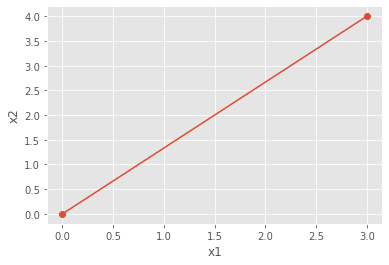

In [6]:
plt.plot([x1, 0], [x2,0], '-o')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

В точке 3, 4 находится вектор A. Его направление исходит из нуля.

Чтобы узнать величину вектора, мы используем формулу:

In [7]:
np.sqrt(x1**2 + x2**2)

5.0

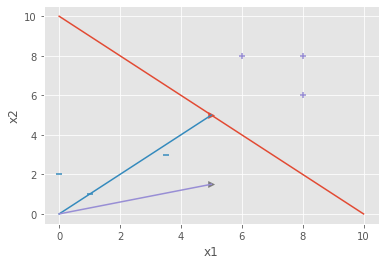

In [8]:
plt.plot([0, 10], [10, 0], '-') #Линия, разделяющие классы
plt.scatter(x=[5], y=[5], marker='>') #стрелка вектора w
plt.plot([0, 5], [0, 5], '-') #Вектор w
plt.scatter(x=[0, 3.5 , 1], y=[2, 3, 1], marker='_') #векторы негативного класса
plt.scatter(x=[6, 8, 8], y=[8, 8, 6], marker='+') #векторы позитивного класса
plt.plot([0, 5], [0, 1.5], '-') #Вектор u (xi)
plt.scatter(x=[5], y=[1.5], marker='>') #стрелка вектора u
plt.ylabel('x2') 
plt.xlabel('x1')
plt.show()

Если u + w + b >= 0, то класс будет положительным

Если u + w + b <= 0, то класс будет отрицательным

Если u + w + b = 0, то класс будет на границе решения

- Нам нужно найти w и b

Создадим уравнение 

Вектор X_(-sv) * Вектор W + b = -1 (отрицательный класс)

Вектор X_(xw) * Вектор W + b = 1 (положительный класс)

- Преобразуем уравнение и получим:

yi = это класс таргета

yi * (Вектор X_(-sv) * Вектор W + b) - 1 = 0 (положительный класс)

yi * (Вектор X_(xw) * Вектор W + b) - 1 = 0 (отрицательный класс)

- В итоге, оказывается, что для обоих классов у нас одно уравнение:

yi * (Вектор X * Вектор W + b) - 1 = 0

- Идем далее:

Определимся с определением support vector - это вектор (точки), которые расположены в пространстве и через которые проходят гиперплоскости их разделяющие:

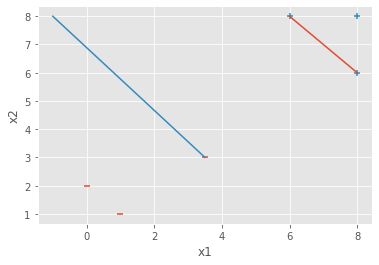

In [9]:
plt.plot([6, 8], [8, 6], '-') #
plt.plot([3.5, -1], [3, 8], '-') 
plt.scatter(x=[0, 3.5 , 1], y=[2, 3, 1], marker='_') #векторы негативного класса
plt.scatter(x=[6, 8, 8], y=[8, 8, 6], marker='+') #векторы позитивного класса
plt.ylabel('x2') 
plt.xlabel('x1')
plt.show()

Проведем гиперплоскость лучше всего разделяющую эти два класса:

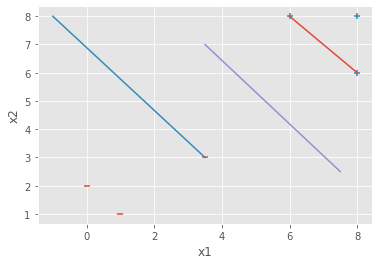

In [10]:
plt.plot([6, 8], [8, 6], '-') #гиперплоскость для полож. класс
plt.plot([3.5, -1], [3, 8], '-') #гиперплоскость для отриц. класса
plt.plot([3.5, 7.5], [7, 2.5], '-') #лучшая гиперплоскость, разделяющая классы
plt.scatter(x=[0, 3.5 , 1], y=[2, 3, 1], marker='_') #векторы негативного класса
plt.scatter(x=[6, 8, 8], y=[8, 8, 6], marker='+') #векторы позитивного класса
plt.ylabel('x2') 
plt.xlabel('x1')
plt.show()

Мы можем найти ширину между двуми точками, разделить её на 2 и получить расстояние от support вектора до гиперплоскости, чтобы построить гиперплоскость

Векторы на синей и оранжевой линии будут иметь 0, а векторы (точки) выше этих линий будут иметь значения 1 и выше

Наша задача: максимизировать эту ширину между векторами и вот уравнение для этого

Width = (X+ - X-) * w / величина(w)

Для X+ и X- у нас уже есть уравнение: yi * (Вектор X * Вектор W + b) - 1 = 0

Упрощаем уравнение:

Width = 2 / величина(w)

Т.к. нам надо увеличить width, то нам нужно уменьшить величину(w)

Другими словами мы можем переписать уравнение в 

минимизировать 1/2 величина(w)^2

Переходим к лагранжу

L(w, b) = 1/2 (величина w)^2 - sum(alphai [yi * (xi*w + b) -1 ])

alphai - множитель лагранжа

Нам нужно минимизировать w и максимизировать b

Это уровнение которое нужно оптимизировать

Таким образом нам нужно дифферинцировать прозводная L по отношению к производной w и прозводную L по отношению к производной b 

## Создание модели с нуля

Создадим данные

In [11]:
data_dict = {-1 : np.array([[1, 7],
                            [2, 8], 
                            [3, 8],]), #для негативного класса
             
            1 : np.array([[5, 1],
                          [6, -1],
                          [7, 3],])} #для позитивного класса

In [12]:
class Support_Vector_Machine:
    def __init__(self, visualization=True): #ни один из методов не вызовется сам по себе, когда инициализируешь класс, кроме данного метод
        self.visualization = visualization #метод для визуализации данных
        self.colors = {1:'r', -1:'b'} #красным - позитивный класс, синим - негативный
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1, 1, 1) 
            
    def fit(self, data):
        self.data = data
        # { ||w|| : [w, b] }
        opt_dict = {}
        #Каждый раз когда, у нас будет вектор, то мы хотим его трансформировать, путем получения dot.product
        transforms = [[1, 1],
                     [-1, 1],
                     [-1, -1],
                     [1, -1]]
        #поиск максимума и минимума
        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)
                    
        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None #чтобы не захламлять память
        
        #мы знаем, что хорошо оптимизировали модель, когда
        #support_vectors yi * (xi @ w + b) = 1
        #мы можем сами выбирать число, к примеру мы можем выбрать число и побольше, если не хотим быть слишком придирчивыми
        #и пока мы не получим даное значение для support_vectors мы будем продолжать шагать
        
        #выделяем шаги для того, чтобы пройти дугу для w
        step_sizes = [self.max_feature_value * 0.1, #делаем большой шаг
                     self.max_feature_value * 0.01, #когда найдем значение функции получше, то делаем шаг поменьше
                     # на этой точке процессору уже будет чуть посложнее
                     self.max_feature_value * 0.001] #когда найдем значение функции еще получше, то делаем шаг еще поменьше
        
        #шаги для b
        b_range_multiple = 5
        
        #нам не нужно делать делать такие же маленькие шаги для b, как мы делаем для W (пр. self.max_feature_value * 0.1)
        b_multiple = 5
        
        # Это проще говоря первый элемент для вектора W
        #умножаем на 10, потому что предпологаем что значение ||w|| должно быть меньше в 10 раз,
        #чем значение максимального признака
        #стоит уточнить, что данная модель svm будет работать корректно только с позитивными
        #значемниями признаков
        latest_optimum = self.max_feature_value * 10
        
        for step in step_sizes:
            #сейчас мы стоим на краю дуги и мы собираемся бросить мяч в дугу
            w = np.array([latest_optimum, latest_optimum]) #вектор
            optimized = False #будет False, пока мы не поняли, что модель оптимизирована
            #работает над тем, чтобы получить минимальную ||w|| и максимальный b 
            while not optimized:
                #arange - тот же range, только можем добавить шаги
                for b in np.arange(-1*(self.max_feature_value * b_range_multiple),
                                  self.max_feature_value * b_range_multiple,
                                  step * b_multiple):
                    for transformation in transforms:
                        w_t = w * transformation #здесь Largrange multipliers
                        found_option = True
                        #здесь самое слабая вещь в SVM
                        #однако SMO немного это исправит
                        #мы хотим для каждого класса сэмпла, чтобы значение из уравнение ниже
                        #было >= 1
                        #yi(xi @ w + b) >= 1
                        #И если у одного класса сэмплов из датасета значение не больше 1.00..
                        #после оптимизации выше,
                        # (мы сообщаем это ниже в if not) , то
                        #мы говорим модели, чтобы она сделала еще один более короткий шаг
                        for i in self.data: #i - это класс 
                            for xi in self.data[i]: #xi - это признаки класса
                                yi = i
                                if not yi*(np.dot(w_t, xi) + b) >= 1:
                                    found_option = False #тогда все отменяется и модели начинает
                                    #новый шаг с более низким значением шага
                                    #print(xi, ':', yi*(np.dot(w_t, xi) + b))
                        #когда все значения класса-сэмплов >= 1, то found_option = True
                        if found_option: 
                            #тогда мы передаем значения в словарь с оптимизацией 
                            opt_dict[np.linalg.norm(w_t)] = [w_t, b] #так находится величина вектра, передаем её в словарь 
            #пока w не станет меньше 0, продолжаем уменьшать w (состоящую из больших чисел в 
            #в признаках * 10)
            #нам не обязателньо чтобы именно w[0] было меньше 0, мы можем взять и w[1] для
            #сравнения, т.к. это одинаковые числа
            #Меньше 0, потому что у нас есть лист с трансформациями и данные трансформации
            #гаранитируют, что мы пройдем через все значения для координат w, в интервале
            # [-self.max_feature_value * 10; +self.max_feature_value * 10] с данным шагом
            #из цикла и оставляем только те, которые нам подходят по условию функции (yi(xi.w+b)>=1).
            #Мы не можем быть уверены, что данное значение будет равно 0
            #потому что оно может его перепрыгнуть, поэтому мы просто берем значением меньше 0.
            #Другими словами мы понимаем, что оптимайзер прошел весь путь со всеми возможными w[0],
            #когда значение w[0] < 0 
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    #Если w = [5, 5]
                    #step = 1
                    #то w - 1 = [4, 4]
                    w = w - step
                            
            norms = sorted([n for n in opt_dict]) #сортируем словарь с оптимизированными значениями величин векторов ||W||
            #берем самое оптимизированное (малое) значение
            #||w|| : [w, b]  
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            #step*2 - умножение не на итерацию, а на само значение шага (max_feat...)
            latest_optimum = opt_choice[0][0] + step*2 #обновляется значение latest_optimum и заново
            #далее идем на следующий шаг, где step = max_feature e* 00.1 и т.д.
            
        for i in self.data: #i - это класс 
            for xi in self.data[i]: #xi - это признаки класса
                yi = i
                print(xi, ':', yi*(np.dot(self.w, xi) + self.b))               

    def predict(self, features):
        # Мы узнаем класс с помощью выявления знака при уравнении (x@w + b). Если знак позитивный, то класс позитивный и т.д.
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
            
        print(features[0], features[1], np.dot(np.array(features),self.w)+self.b)
        return classification
    
    def visualize(self): #это чист, чтобы мы видели результат
        #data_dict - первоначальный датасет
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        
        # hyperplane = x @ w + b
        # v = x @ w + b
        #если v = 1, то psv, если v = -1, то nsv
        #positive support vector = 1
        #negative support vector = -1
        #decision boundary = 0
        def hyperplane(x, w, b, v): #визуализирует гиперплоскость, она ни на что не влияет в алгоритме 
            return (-w[0]*x-b+v) / w[1]
        
        #умножение на 0.9 - это, чтобы линия не выходила за пределы графика
        datarange = (self.min_feature_value * 0.9, self.max_feature_value*1.1)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        
        #positive support vector hyperplane (w @ x + b) = 1 (v)
        #здесь у нас две точки для того, чтобы начертить линию
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1) #получится скалярное значение. На графике это будет y - значение
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min, hyp_x_max], [psv1, psv2], 'k') #первое x-ы, второе y-ки
        
        #negative support vector hyperplane (w @ x + b) = - 1 (v)
        #здесь у нас две точки для того, чтобы начертить линию
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1, ) #получится скалярное значение. На графике это будет y - значение
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min, hyp_x_max], [nsv1, nsv2], 'k') #первое x-ы, второе y-ки
        
        #decision boundary hyperplane (w @ x + b) = 0 (v)
        #здесь у нас две точки для того, чтобы начертить линию
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0) #получится скалярное значение. На графике это будет y - значение
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min, hyp_x_max], [db1, db2], 'y--') #первое x-ы, второе y-ки
        
        plt.show()

Optimized a step.
Optimized a step.
Optimized a step.
[1 7] : 1.2239999999999465
[2 8] : 1.2239999999999465
[3 8] : 1.000000000000098
[5 1] : 1.015999999998539
[ 6 -1] : 1.6879999999980846
[7 3] : 1.015999999998539


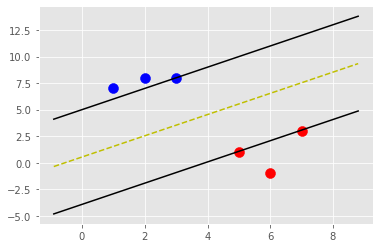

In [13]:
svm = Support_Vector_Machine()
svm.fit(data=data_dict)
svm.visualize()

Optimized a step.
Optimized a step.
Optimized a step.
[1 7] : 1.2239999999999465
[2 8] : 1.2239999999999465
[3 8] : 1.000000000000098
[5 1] : 1.015999999998539
[ 6 -1] : 1.6879999999980846
[7 3] : 1.015999999998539
0 10 -2.1199999999993406
1 3 -0.3280000000005523
3 4 -0.10400000000070375
3 5 -0.3280000000005523
5 5 0.11999999999914479
5 6 -0.10400000000070375
6 -5 2.583999999997479
5 8 -0.5520000000004008


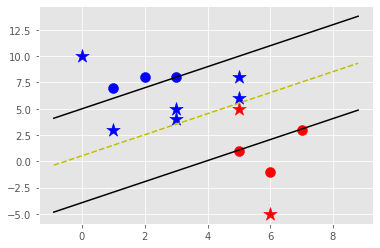

In [14]:
svm = Support_Vector_Machine()
svm.fit(data=data_dict)
predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]

for p in predict_us:
    svm.predict(p)

svm.visualize()
plt.show()

## Sofr Margin SVM

В реальности, наши данные сложно будет разделить таким способом, т.к. они не будут поддаваться делением через простую прямую, тогда в действия вступают ядра, которые позволяют добавить в данные дополнительные измерения, чтобы мы смогли разделить классы. Однако, повышается шанс переобучения. К примеру, может произойти такая ситуация, что все сэмплы станут опорными векторами и тогда модель будет плохо работать на тестовой выборке. В реальности нужно следить за тем, чтобы...

**количество опорных векторов / количество сэмплов < 10%**

Когда мы используем большое количество опорных векторов и чертим через них гиперплоскость, то это Hard Margin SVM, когда мы проводим примерную линию, и при этом мы имеем ситуацию, что некоторые сэмплы лежат на стороне не своего класса, однако гиперплоскость разделяющая данные все еще имеет вид прямой, а не изогнутой линии, и таким образом уменьшается шанс переобучения, то мы применямм метод Soft Margin SVM

Мы можем рассчитать ошибку, которая возникает, когда некоторые сэмплы при таком раскладе лежат вне своего настоящего класса, когда мы разделили сэмплы с помощью введения переменной Slack, тогда условие функции будет таким:

**yi(xi @ wi + b) >= 1 - Slack**

В такой ситуации Slack должен быть >= 0, если Slack = 0, то у нас Hard Margin

Slack - это погрешность, которую мы позволяем модели, при подборе w и b. В реальности мы хотим минимизировать Slack

Таким образом мы хотим минимизировать уже...

**1/2||w||^2 + C * sum_i(Slack_i)**

Откуда появилось С? Если мы увеличим значение C, то мы, таким образом, хотим чтобы было меньше "нарушений" со стороны модели, таким образом мы больше "наказываем модель" за наличие нарушений. И если мы уменьшим С, то мы будет более снисходительны к ошибкам. Другими словами C позволяет нам решить на сколько нам важен Slack в отношении минимизации ||w||. Если мы делаем меньше C * sum_i(Slack_i), то мы даем большую "свободу" для минимазации ||w||.
Можно сказать, что ||w|| отвечает за изогнутость гиперплоскости, а C за прямость гиперплоскости. Если мы повываем C, то модели будет строить более прямую гиперлоскость, если мы уменьшаем С, то гиперплоскость будет более кривой.

## SVM с использованием ядер

Методы для ядер

In [15]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [17]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        #если C = none, то hard margin
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix (Создание значение для quadratic programming solver)
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # решение QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers (получение alphas)
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv] 
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        #выводит на экран сколько опорных векторов
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept (B - bias)
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector (W)
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
            
    #Для получения предсказания
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        #создает данные, которые можно линейно разделить
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        #создает данные которые нельзя разделить линейно (для этого требуется ядро)
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        #для графика данных, которые можно разделить линейно
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        #для графика данных, которые нельзя разделить линейно
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

     pcost       dcost       gap    pres   dres
 0: -3.6873e+01 -8.5389e+01  1e+03  3e+01  2e+00
 1: -6.6028e+01 -7.1174e+01  5e+02  2e+01  1e+00
 2: -4.0741e+01 -1.8804e+01  2e+02  6e+00  4e-01
 3: -1.0877e+00 -5.3751e-01  1e+01  3e-01  2e-02
 4: -2.2192e-01 -4.6023e-01  4e+00  8e-02  5e-03
 5: -1.7087e-01 -4.7538e-01  3e+00  5e-02  3e-03
 6: -5.8367e-02 -2.8058e-01  5e-01  6e-03  5e-04
 7: -1.0439e-01 -1.7791e-01  1e-01  2e-03  1e-04
 8: -1.1172e-01 -1.7688e-01  1e-01  1e-03  9e-05
 9: -1.3124e-01 -1.5648e-01  5e-02  5e-04  3e-05
10: -1.2897e-01 -1.5728e-01  5e-02  4e-04  3e-05
11: -1.4137e-01 -1.5109e-01  1e-02  2e-05  1e-06
12: -1.4825e-01 -1.4908e-01  9e-04  1e-06  9e-08
13: -1.4889e-01 -1.4891e-01  3e-05  3e-08  2e-09
14: -1.4891e-01 -1.4891e-01  1e-06  8e-10  6e-11
15: -1.4891e-01 -1.4891e-01  1e-08  9e-12  6e-13
Optimal solution found.
9 support vectors out of 180 points
20 out of 20 predictions correct


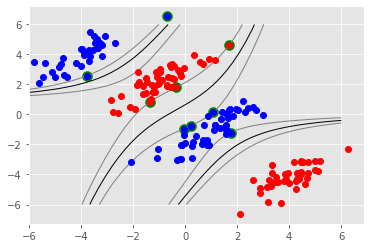

In [21]:
#test_linear()
test_non_linear()
#test_soft()

## Дополнительно про SVM

tol - в scikit используется не yi*(np.dot(w_t, xi) + b) >= 1, а yi*(np.dot(w_t, xi) + b) - 1>= 0. По дефолту tol = 1e - 3 (-0.28171817154), но мы можем изменить это под наше усмотрение

max_iter - наибольшее кол-во итераций, пока не достигнуто значение tol

decision_function_shape - Т.к. в начале было сказано, что SVM - это бинарный классификатор, то у нас есть два пути решения проблемы, когда мы имеем несколько классов: OVR - one versus rest(По большей части все используют этот концеп). OVO - one versus one.

Аттрибуты:

n_support - кол-во опорных векторов

kernel - вид ядра

degree - степень P в полиномиальном ядре

probability - вероятность быть таким-то классом для сэмпла

class_weight - есть классы не сбалансированы, то стоит учесть этот момент, т.к. по дефолту для всех классов стоит вес = 1. Лучше ставить параметр balanced.